This notebook contains code to measure the burden of deleterious variation from STRs

In [1]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import pyplot as plt
import sys
import pandas as pd

sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Simulation_functions import *

Populating the interactive namespace from numpy and matplotlib


# New mutations - based on models

In [2]:
# For each class of STRs, we want:
# - motif/opt allele
# - number of STRs
# - mutation rate
# - mean s per mutation
# Then will sum across all categories

# Read in joint results
joint_results = {}
sistr2_scores_file = open('/storage/BonnieH/selection_project/analysis/SISTR2_scores_by_motif_corrected_num_loci.txt', 'r')
sistr2_scores_file.readline()
for line in sistr2_scores_file:
    info = line.strip().split('\t')
    period = int(info[0])
    optimal_ru = int(info[1])
    motif = info[2]
    num_loci = int(info[3])
    est_a = float(info[4])
    est_b = float(info[5])
    joint_results[(period,optimal_ru,motif,num_loci)] = (est_a,est_b)
sistr2_scores_file.close()

# List contents: mu, beta, p, l, optimal ru for the mu value
# Mutation model parameters for different motifs
motif_info = {}
motif_info['eurodem_prior2_dinuc_e_1kg_euro'] = [10**-5, 0.3, 0.6, 0.15, 6]
motif_info['eurodem_prior2_dinuc_d_1kg_euro'] = [10**-4.6, 0.3, 0.6, 0.135, 6]
motif_info['eurodem_prior2_trinuc_e_1kg_euro'] = [10**-6, 0.3, 0.9, 0.3, 5] 
motif_info['eurodem_prior2_tetranuc_b_1kg_euro'] = [10**-5, 0.3, 0.9, 0.25, 3]
motif_info['eurodem_prior2_tetranuc_c_1kg_euro'] = [10**-5.5, 0.3, 0.9, 0.42, 3]
motif_info['eurodem_prior2_tetranuc_d_1kg_euro'] = [10**-6, 0.3, 0.9, 0.45, 3]

# Mutation model settings for different motifs (inferred by SISTR2)
trinuc_motifs = ['ACC','AGG','AGC','CCG','AAG','AAC','ATC','AAT']
dinuc_motifs  = ['AC','AG','AT'] 
tetranuc_motifs = ['AAGG','AAAT','ATCC','AATC','AAAC','AATG','ACAT','AGAT','AAAG'] 
mut_setting = {}
mut_setting['AC'] = 'eurodem_prior2_dinuc_e_1kg_euro'
mut_setting['AG'] = 'eurodem_prior2_dinuc_e_1kg_euro'
mut_setting['AT'] = 'eurodem_prior2_dinuc_d_1kg_euro'
for mot in trinuc_motifs:
    mut_setting[mot] = 'eurodem_prior2_trinuc_e_1kg_euro'
for mot in ['AAAG', 'AAGG', 'AGAT']:
    mut_setting[mot] = 'eurodem_prior2_tetranuc_b_1kg_euro'
for mot in ['ACAT', 'AAAT']:
    mut_setting[mot] = 'eurodem_prior2_tetranuc_c_1kg_euro'
for mot in ['AATC', 'AATG', 'ATCC', 'AAAC']:
    mut_setting[mot] = 'eurodem_prior2_tetranuc_d_1kg_euro'

    
motifs_ = []
opts_ = []
numloci_ = []
means_ = []
muts_ = []
# Get burden for each category
for elem in joint_results:
    # Get params for this class
    setting_info = mut_setting[elem[2]]
    mut_info = motif_info[setting_info]
    num_loci = elem[3] # target size
    
    # Get mutation rate   
    log_mu_prime = np.log10(mut_info[0])+mut_info[3]*(elem[1] - mut_info[4])
    mu_prime = 10**log_mu_prime
    
    if mu_prime < 10**-8: mu_prime = 10**-8 
    if mu_prime > 10**-3: mu_prime = 10**-3

    # Get mean s value of a new mutation
    # Sum over all possible step sizes
    mean_s = 0
    for i in range(-20, 20):
        if elem[1] + i <= 0: continue # can't have negative repeat copy nmber
        prob_step = GetStepSizeProb(0, i, mut_info[1], mut_info[2])
        sval = joint_results[elem][0]*joint_results[elem][1]*abs(i) # a*b*step
        mean_s += prob_step*sval
    
    motifs_.append(elem[2])
    opts_.append(elem[1])
    numloci_.append(num_loci)
    means_.append(mean_s)
    muts_.append(mu_prime)

data = pd.DataFrame({"motif": motifs_,
             "opt": opts_,
             "numloci": numloci_,
             "mean.s": means_,
             "mu": muts_})

In [3]:
# Get burden

data["burden"] = data.apply(lambda x: 2*x["mu"]*x["mean.s"]*x["numloci"], 1)
data.to_csv("figure4-burden-numbers.csv")
print(np.sum(data["burden"]))

# Summarize overall
num_strs = np.sum(data["numloci"])
mean_s = np.sum(data.apply(lambda x: x["numloci"]*x["mean.s"], 1))/np.sum(data["numloci"])
mean_mu = np.sum(data.apply(lambda x: x["numloci"]*x["mu"], 1))/np.sum(data["numloci"])
burden = 2*mean_mu*num_strs*mean_s
print("Num STRs: %s"%(num_strs))
print("Mean s/mutation: %s"%(mean_s))
print("Mean mu: %s"%(mean_mu))
print("Overall burden: %s"%burden)

0.051146734481617315
Num STRs: 74119
Mean s/mutation: 0.0006540766876531336
Mean mu: 0.00019606154782613472
Overall burden: 0.01900993554167439


# Supp fig. 12 - burden comparison by motif

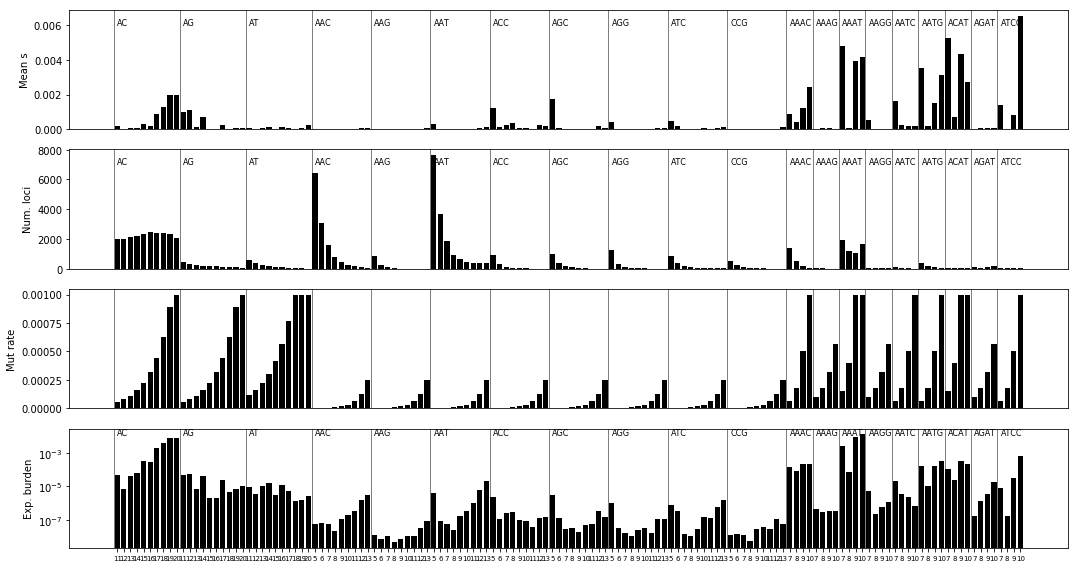

In [64]:
data["period"] = data["motif"].apply(len)
data = data.sort_values(["period","motif","opt"])
vertlines = [-0.5]
motifs = [data["motif"].values[0]]
mpos = [0]
for i in range((data.shape[0])-1):
    if data["motif"].values[i] != data["motif"].values[i+1]:
        vertlines.append(i+0.5)
        motifs.append(data["motif"].values[i+1])
        mpos.append(i+1)

fig = plt.figure()
fig.set_size_inches((15, 8))
ax = fig.add_subplot(411)
ax.bar(range(data.shape[0]), (data["mean.s"]), color="black")
ax.set_xticks([])
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
for i in range(len(motifs)):
    ax.annotate(motifs[i], (mpos[i], 0.006), size=8)
ax.set_ylabel("Mean s")
#ax.set_yscale('log')


ax = fig.add_subplot(412)
ax.bar(range(data.shape[0]), (data["numloci"]), color="black")
ax.set_xticks([])
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
for i in range(len(motifs)):
    ax.annotate(motifs[i], (mpos[i], 7000), size=8)
ax.set_ylabel("Num. loci")

ax = fig.add_subplot(413)
ax.bar(range(data.shape[0]), (data["mu"]), color="black")
ax.set_xticks([])
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
#for i in range(len(motifs)):
#    ax.annotate(motifs[i], (mpos[i], 7000), size=8)
ax.set_ylabel("Mut rate")

ax = fig.add_subplot(414)
ax.bar(range(data.shape[0]), (data["burden"]), color="black")
ax.set_xticks(range(data.shape[0]))
for vl in vertlines:
    ax.axvline(x=vl, color="black", linewidth=0.5)
for i in range(len(motifs)):
    ax.annotate(motifs[i], (mpos[i], 0.012), size=8)    
ax.set_xticklabels(data.apply(lambda x: str(x["opt"]), 1), rotation=0, size=7)
ax.set_ylabel("Exp. burden")
ax.set_yscale('log')
fig.tight_layout()

fig.savefig("SuppFig-burdenByMotif.pdf")
#data

# New mutations - based on observed de novos


In [4]:
joint_results2 = {} # motif, opt -> s
for elem in joint_results:
    joint_results2[(elem[2], elem[1])] = joint_results[elem][0]*joint_results[elem][1]

In [99]:
# Load gangstr ref
gref_file = "/gymreklab-tscc/mousavi/analysis/1000genomes/additional_runtime_files/regions/hg38_supp.bed"
gref = pd.read_csv(gref_file, sep="\t", names=["chrom","start","end","period","motif","repseq"])
gref["optimal_ru"] = gref.apply(lambda x: int((x["end"]-x["start"]+1)/x["period"]), 1)

In [141]:
NUMBS = 100

# Load all de novos + filter
denovos_file = "/storage/hziaeija/variant_trio/trio_variants/monstr_all_filters/CEU_all_filters.csv"
denovo = pd.read_csv(denovos_file)
denovo = denovo[denovo["period"].apply(lambda x: x>=2 and x<=4)]
denovo = denovo[(denovo["encl_mother"]==0) & (denovo["encl_father"]==0) & (denovo["encl_child"]>=2)]
denovo["start"] = denovo["pos"]
denovo = pd.merge(denovo, gref[["chrom","start","period","motif","optimal_ru"]], on=["chrom","start","period"])
denovo["sistr2"] = denovo.apply(lambda x: joint_results2.get((x["motif"], x["optimal_ru"]), float("nan")), 1)
denovo = denovo[~np.isnan(denovo["sistr2"])]

def BootstrapSVals(all_svals_2):
    bs_svals_2 = []
    for i in range(len(all_svals_2)):
        ind = random.randint(0, len(all_svals_2))
        bs_svals_2.append(all_svals_2[ind])
    return bs_svals_2

def GetLowerBS(vals):
    return np.percentile(vals, [2.5])[0] #np.min(vals)

def GetUpperBS(vals):
    return np.percentile(vals, [97.5])[0] #np.max(vals)


for sample in ["NA12864", "NA10865","NA10845" ]:
    denovo_ = denovo[denovo["child"]==sample].copy()
    ddata = denovo_
    ddata["s2.new"] = ddata.apply(lambda x: (x["newallele"]-x["optimal_ru"])*x["sistr2"], 1)
    ddata["s2.old"] = ddata.apply(lambda x: (x["newallele"]-x["mutsize"]-x["optimal_ru"])*x["sistr2"], 1)
    ddata["s2.delta"] = ddata["s2.new"]-ddata["s2.old"]

    print ("##### %s #####"%sample)
    print("Num mutations: %s"%ddata.shape[0])
    print("Num mutations neg - sistr2: %s"%ddata[ddata["s2.delta"]>0].shape[0])

    # Get bootstrap CIs for all mutations, only negative - TODO
    all_svals_2 = list(ddata["s2.delta"])
    
    burden_bs_2 = []
    burden_neg_bs_2 = []
    
    # Bootstrap sample mutations
    for i in range(NUMBS):
        bs_svals_2 = BootstrapSVals(all_svals_2)
        burden_bs_2.append(np.sum(bs_svals_2))
        burden_neg_bs_2.append(np.sum([item for item in bs_svals_2 if item > 0]))
    
    print("Total burden (sistr2): %s (%s-%s)"%(np.sum(ddata["s2.delta"]), GetLowerBS(burden_bs_2), GetUpperBS(burden_bs_2)))
    print("Total burden only neg (sistr2): %s (%s-%s)"%(np.sum(ddata[ddata["s2.delta"]>0]["s2.delta"]), GetLowerBS(burden_neg_bs_2), GetUpperBS(burden_neg_bs_2)))
    

##### NA12864 #####
Num mutations: 44
Num mutations neg - sistr2: 30
Total burden (sistr2): 0.015528033261170004 (0.0021924287313340013-0.03394276430340225)
Total burden only neg (sistr2): 0.023044235013710005 (0.012215134528856503-0.038099608668146254)
##### NA10865 #####
Num mutations: 56
Num mutations neg - sistr2: 40
Total burden (sistr2): 0.011263137321959998 (-0.006497389356753253-0.039017541613674725)
Total burden only neg (sistr2): 0.027481502432389997 (0.0138676909182785-0.047767927996483495)
##### NA10845 #####
Num mutations: 20
Num mutations neg - sistr2: 15
Total burden (sistr2): 0.014940432778029998 (-0.0004189909325777496-0.030452908913727247)
Total burden only neg (sistr2): 0.019543998340849997 (0.006129031681813753-0.0314229606203805)
